# Modelo de predição de falhas em máquinas industriais
## Sobre o problema

Com o objetivo de solucionar o problema de prever quando uma máquina industrial irá falhar dentro de uma empresa, usou-se um conjunto de dados com a classificação de manutenção dessas máquinas.

Como os conjuntos de dados reais de manutenção preditiva são geralmente difíceis de obter e, em particular, difíceis de publicar, foi utilizado um conjunto de dados sintético que reflete a manutenção preditiva real encontrada na indústria, até onde se sabe.

Referência do dataset: https://www.kaggle.com/datasets/shivamb/machine-predictive-maintenance-classification

## Campos

Os campos descritos a seguir estão presentes no dataset e serão usados para a predição do modelo.

**UID**: identificador exclusivo variando de 1 a 10.000

**productID**: consistindo em uma letra L, M ou H e um número de série específico da variante.

***Type***: L, M ou H para baixa (50% de todos os produtos), média (30%) e alta (20%) como variantes de qualidade.

**air temperature [K]**: ou *temperatura do ar*. Gerada usando um processo de passeio aleatório posteriormente normalizado para um desvio padrão de 2 K em torno de 300 K.

**process temperature [K]**: ou *temperatura do processo*. Gerada usando um processo de passeio aleatório normalizado para um desvio padrão de 1 K, adicionado à temperatura do ar mais 10 K.

**rotational speed [rpm]**: ou *velocidade de rotação*. Calculada a partir de potência de 2860 W, sobreposta a um ruído normalmente distribuído

**torque [Nm]**: os valores de torque são normalmente distribuídos em torno de 40 Nm com Ïƒ = 10 Nm e sem valores negativos.

**tool wear [min]**: ou *desgaste da ferramenta*. As variantes de qualidade H/M/L adicionam 5/3/2 minutos de desgaste da ferramenta à ferramenta utilizada no processo

O rótulo de '**falha da máquina**' que indica se a máquina falhou neste ponto de dados específico para qualquer um dos seguintes modos de falha é verdadeiro.

## Objetivo

Esse notebook tem como objetivo criar um modelo de machine-learning capaz de identificar se uma máquina industrial dentro de uma empresa apresenta alguma falha, tornando-se viável a previsão e prevenção de falhas de equipamentos em cenários futuros.

## Importação das bibliotecas

In [1]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from pickle import dump

# Biblioteca para tratamento de variável categórica nominal no pré-processamento
!pip install category_encoders
from category_encoders.one_hot import OneHotEncoder

# Biblioteca para balanceamento do dataset
!pip install -U imbalanced-learn
from imblearn.under_sampling import RandomUnderSampler

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 713.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 1.3 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.10.1
    Uninstalling imbalanced-learn-0.10.1:
      Successfully uninstalled imbalanced-learn-0.10.1


##  Importação dos dados e sua leitura


In [2]:
# Informa a URL de importação do dataset
url = "https://raw.githubusercontent.com/MicaelRiboura/industrial-maintenance-mvp/main/api/model_ml/dataset/predictive_maintenance.csv"

# Lê o arquivo
dataset = pd.read_csv(url, delimiter=',')

# Mostra as primeiras linhas do dataset
dataset.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


## Pré-Processamento de Dados



### Tratamento de variável categórica nominal

A variável ***Type*** presente no conjunto de dados é um exemplo de variável categórica nominal. Portanto, foi utilizada a técnica ***one-hot encoding*** para a transformação dessa variável categórica em uma representação numérica com o propósito de ser inserida como entrada no modelo de machine-learning.

A classe ***OneHotEncoder*** é instanciada dentro de uma variável informando a coluna ***Type*** que será transformada no *dataset* (ou conjunto de dados). Na linha seguinte, o *dataset* original é modificado, transformando a coluna Type **em 3 colunas**: *Type_1, Type_2 e Type_3*, representadas com os valor booleanos de 0 e 1, conforme o trecho de código abaixo.

In [3]:
one_hot_enc = OneHotEncoder(cols=['Type'])
prepared_dataset = one_hot_enc.fit_transform(dataset)
prepared_dataset.head()

,UDI,Product ID,Type_1,Type_2,Type_3,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,1,0,0,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,0,1,0,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,0,1,0,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,0,1,0,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,0,1,0,298.2,308.7,1408,40.0,9,0,No Failure


### Selecionando as features que serão usadas no modelo

Durante a análise do conjunto de dados, percebeu-se que as colunas ***UDI*** e ***Product ID*** tem apenas o objetivo de identificar cada registro, não sendo úteis para o modelo fazer a predição.

Portanto, no trecho de código abaixo, essas colunas são removidas do dataset, mantendo-se apenas as que serão usadas no modelo.

In [4]:
prepared_dataset = prepared_dataset.drop('UDI', axis=1)
prepared_dataset = prepared_dataset.drop('Product ID', axis=1)
prepared_dataset.head()

,Type_1,Type_2,Type_3,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,0,0,298.1,308.6,1551,42.8,0,0,No Failure
1,0,1,0,298.2,308.7,1408,46.3,3,0,No Failure
2,0,1,0,298.1,308.5,1498,49.4,5,0,No Failure
3,0,1,0,298.2,308.6,1433,39.5,7,0,No Failure
4,0,1,0,298.2,308.7,1408,40.0,9,0,No Failure


A coluna ***Failure Type***, também é uma variável categórica nominal, porém representa uma categoria alvo para predição, ou seja, o modelo poderia classificar o tipo de falha da máquina. Entretanto, para a simplificação do modelo, essa coluna será descartada no trecho abaixo.

In [5]:
prepared_dataset = prepared_dataset.drop('Failure Type', axis=1)
prepared_dataset.head()

,Type_1,Type_2,Type_3,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
0,1,0,0,298.1,308.6,1551,42.8,0,0
1,0,1,0,298.2,308.7,1408,46.3,3,0
2,0,1,0,298.1,308.5,1498,49.4,5,0
3,0,1,0,298.2,308.6,1433,39.5,7,0
4,0,1,0,298.2,308.7,1408,40.0,9,0


## Separação em conjunto de treino e teste com holdout

Com o objetivo de treinar e avaliar diferentes modelos, é necessário separá-los em conjunto de treino e teste, como no trecho abaixo, utilizando a técnica holdout.

In [6]:
test_size = 0.20 # tamanho do conjunto de teste
seed = 7 # semente aleatória

# Separação em conjuntos de treino e teste
array = prepared_dataset.values
X = array[:, 0:8]
y = array[:,8]

X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação

## Modelagem e Inferência

### Criação e avaliação de modelos: linha base

No trecho de código a seguir foram escolhidos 4 modelos de machine-learning (KNN - K-Nearest Neighbour, CART - Classification And Regression Tree, NB - Naive-Bayes, SVM - Support Vector Machine) para a avaliação inicial de desempenho de cada um com base na acurácia.

KNN: 0.967634 (0.003176)
CART: 0.977080 (0.006492)
NB: 0.958327 (0.004085)
SVM: 0.964995 (0.001038)


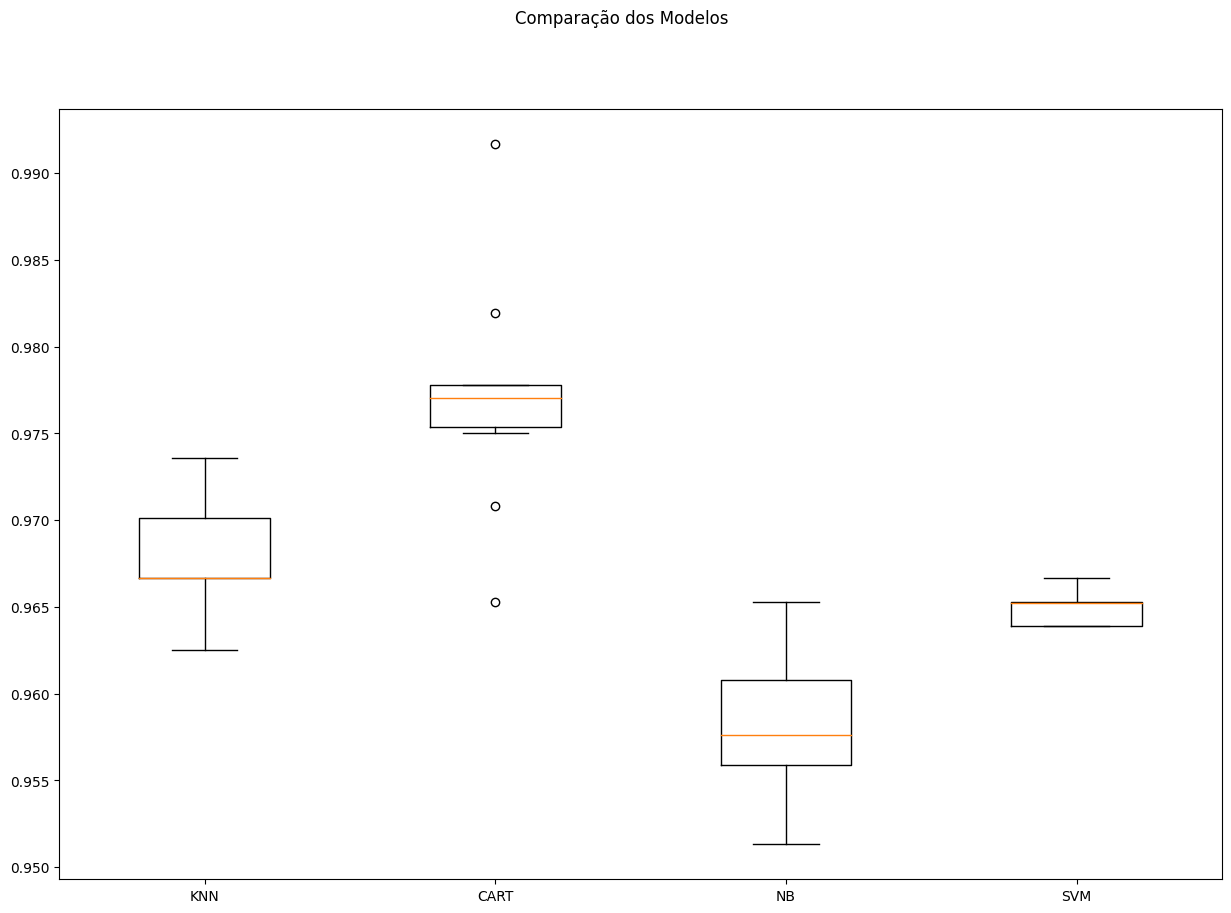

In [7]:
np.random.seed(7) # definindo uma semente global

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## Criação e avaliação: dados padronizados e normalizados

No trecho de código a seguir foram realizadas a versão original, padronizada e normalizada dos 4 modelos de machine-learning escolhidos, com o objetivo de realizar uma avaliação refinada de desempenho de cada um com base na acurácia, e por fim, elencar o melhor modelo. Além disso, foi avaliado o valor de recall e desvio padrão.

Modelo: KNN-orig - Acurácia: 0.968 - Desvio Padrão: 0.003 - Recall: 0.159
Modelo: CART-orig - Acurácia: 0.977 - Desvio Padrão: 0.006 - Recall: 0.794
Modelo: NB-orig - Acurácia: 0.958 - Desvio Padrão: 0.004 - Recall: 0.175
Modelo: SVM-orig - Acurácia: 0.965 - Desvio Padrão: 0.001 - Recall: 0.016
Modelo: KNN-padr - Acurácia: 0.971 - Desvio Padrão: 0.002 - Recall: 0.365
Modelo: CART-padr - Acurácia: 0.978 - Desvio Padrão: 0.007 - Recall: 0.778
Modelo: NB-padr - Acurácia: 0.958 - Desvio Padrão: 0.004 - Recall: 0.175
Modelo: SVM-padr - Acurácia: 0.971 - Desvio Padrão: 0.002 - Recall: 0.175
Modelo: KNN-norm - Acurácia: 0.970 - Desvio Padrão: 0.003 - Recall: 0.286
Modelo: CART-norm - Acurácia: 0.977 - Desvio Padrão: 0.006 - Recall: 0.794
Modelo: NB-norm - Acurácia: 0.958 - Desvio Padrão: 0.004 - Recall: 0.175
Modelo: SVM-norm - Acurácia: 0.965 - Desvio Padrão: 0.001 - Recall: 0.016


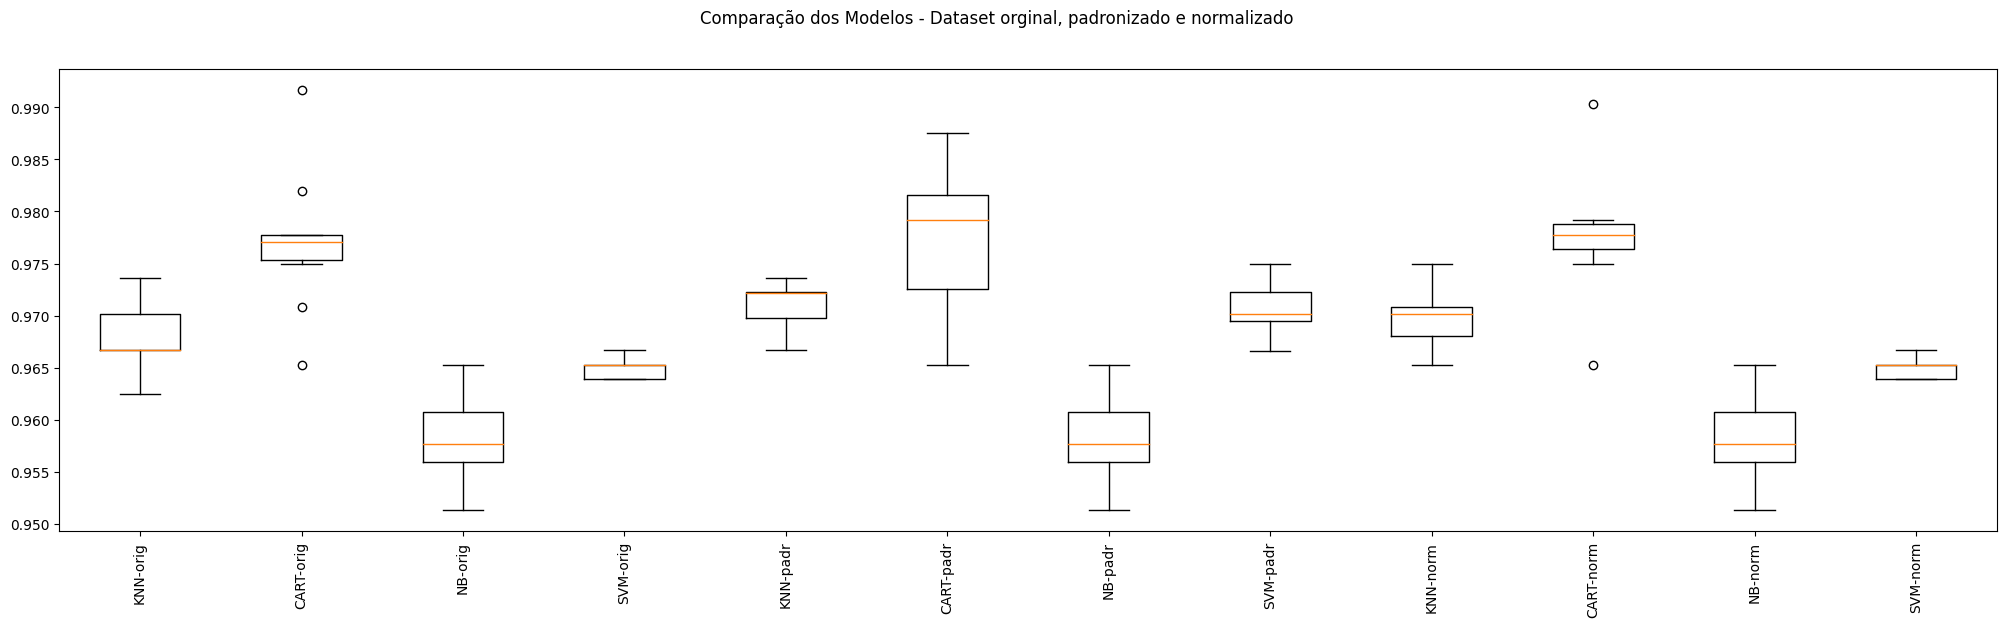

In [8]:
np.random.seed(7) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []


# Criando os elementos do pipeline

# Algoritmos que serão utilizados
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())


# Montando os pipelines

# Dataset original
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))

# Dataset Padronizado
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))

# Dataset Normalizado
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))

# Armazenamento do melhor modelo e acurácia
best_accuracy = 0
best_model = None

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results.append(cv_results)
    names.append(name)
    msg = "Modelo: %s - Acurácia: %.3f - Desvio Padrão: %.3f - Recall: %.3f" % (name, cv_results.mean(), cv_results.std(), recall_score(y_test, y_pred)) # formatando para 3 casas decimais
    print(msg)

    # Armazena o melhor modelo, seu nome e sua acurácia
    if cv_results.mean() > best_accuracy:
      best_accuracy = cv_results.mean()
      best_model = (name, model)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

## Balanceamento do Dataset
Na análise anterior, percebe-se que a maior acurácia é de aproximadamente 98%, entretanto, o recall é de apenas aproximadamente 80%. Isso acontece quando há desbalanceamento do dataset.

Ao analisar o dataset, pode-se observar que os dados usados para o treinamento do modelo estão desbalanceados, como pode-se ver no trecho de código a seguir, em que são apresentados os números de máquinas registradas com e sem falhas:

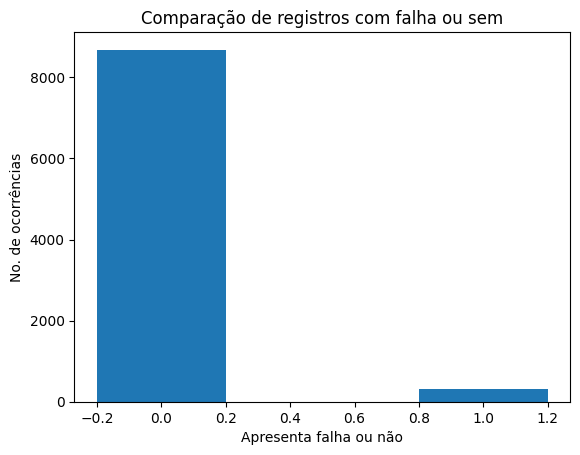

In [9]:
names, values = np.unique(dataset['Target'], return_counts=True)

plt.bar(names, values, width = 0.4)
plt.xlabel("Apresenta falha ou não")
plt.ylabel("No. de ocorrências")
plt.title("Comparação de registros com falha ou sem")
plt.show()

Para visualizar melhor o desbalanceamento, foi analisada a matriz de confusão no trecho de código a seguir, que são os valores no qual o cálculo do recall se baseia.

In [10]:
name, model = best_model
model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[1712,   25],
       [  13,   50]])

Para balancear o dataset, foi utilizada a técnica de ***oversampling***, que  consiste em manter todos os dados da classe com maior frequência e aumentar a quantidade dos que estão na classe de menor frequência. Essa técnica foi realizada no trecho a seguir, podendo visualizar os dados balanceados no gráfico.

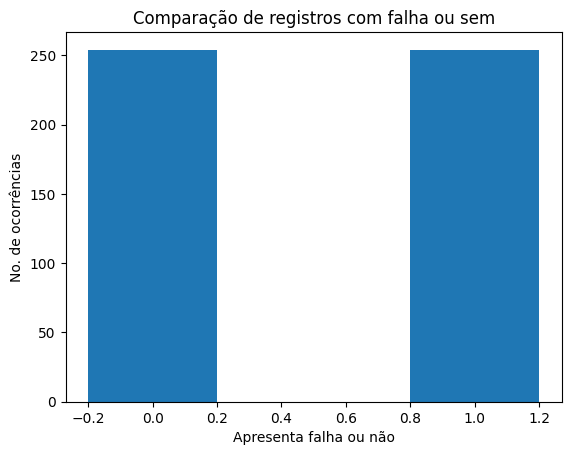

In [11]:
rus = RandomUnderSampler(random_state=42)

X_res, y_res = rus.fit_resample(X_train, y_train)

names, values = np.unique(y_res, return_counts=True)

plt.bar(names, values, width = 0.4)
plt.xlabel("Apresenta falha ou não")
plt.ylabel("No. de ocorrências")
plt.title("Comparação de registros com falha ou sem")
plt.show()

Ao treinar o melhor modelo escolhido com o dataset balanceado, é possível notar uma melhora na pontuação do recall. Apesar da queda da pontuação da acurácia, chegou-se ao resultado de ambas as métricas estarem perto de 90%.

In [12]:
name, model = best_model

model2 = model.fit(X_res, y_res)
y_pred_balanced = model2.predict(X_test)

from sklearn.metrics import recall_score, accuracy_score
print('Acurácia: %.3f' % (accuracy_score(y_test, y_pred_balanced)))
print('Recall: %.3f' % (recall_score(y_test, y_pred_balanced)))

Acurácia: 0.877
Recall: 0.889


## Otimização de Hiperparâmetros

Com o objetivo de experimentação e comparação com o melhor modelo escolhido, os hiperparâmetros do segundo modelo com maior resultado de acurácia, o KNN, foram otimizados para serem treinados com o dataset balanceado. Contudo, ainda não ficaram com resultados suficientes para superar o modelo de Árvore de Classificação e Regressão (CART).


In [14]:
# Tuning do KNN

np.random.seed(7) # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
knn = ('KNN', KNeighborsClassifier())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('knn-orig', Pipeline(steps=[knn])))
pipelines.append(('knn-padr', Pipeline(steps=[standard_scaler, knn])))
pipelines.append(('knn-norm', Pipeline(steps=[min_max_scaler, knn])))

param_grid = {
    'KNN__n_neighbors': [1,3,5,7,9,11,13,15,17,19,21],
    'KNN__metric': ["euclidean", "manhattan", "minkowski"],
}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_res, y_res)
    # imprime a melhor configuração
    print("Sem tratamento de missings: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))


Sem tratamento de missings: knn-orig - Melhor: 0.864275 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 7}
Sem tratamento de missings: knn-padr - Melhor: 0.864196 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 9}
Sem tratamento de missings: knn-norm - Melhor: 0.868157 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 9}


## Exportação do melhor modelo
Com base em sua acurácia, o trecho de código a seguir exporta o melhor modelo para um arquivo pickle, que poderá ser embarcado em um sistema web, por exemplo.

In [ ]:
from pickle import load
name, model = best_model
print(f'Melhor modelo escolhido: {name}')

# model = DecisionTreeClassifier()

# Fit the model on the training data
model2.fit(X_res, y_res)

# Salva o modelo no disco
filename = '/content/model.pkl'
dump(model2, open(filename, 'wb'))

loaded_model = load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print('Score: %.3f' % (result))

Melhor modelo escolhido: CART-padr
Score: 0.860


## Conclusão

Em resumo, para a criação do modelo de machine-learning, foi necessário um pré-processamento dos dados, tratando variáveis categóricas e removendo variáveis não úteis para o treinamento do modelo. Após esse passo, foi possível separar a base de dados em um conjunto de treino e outro de teste com a técnina de separação holdout. Com os conjuntos separados, foram analisados 4 modelos diferentes de machine-learning, passando pelo processo de padronização e normalização. Em síntese, foi escolhido o melhor modelo com base em sua acurácia e exportado para um arquivo, possibilitando ser embarcado em um sistema web, por exemplo.

Por fim, concluiu-se que o modelo **Classification and Regression Tree (Árvore de Classificação e Regressão)** foi escolhido como solução mais eficiente para a predição de uma máquina industrial apresentar alguma falha dentro da empresa.

Uso desse modelo em uma aplicação web: https://github.com/MicaelRiboura/industrial-maintenance-mvp



### Melhoria Futura

Outro ponto para o aperfeiçoamento futuro do modelo, é além de prever se um equipamento apresentará falha ou não, também classificar o tipo de falha apresentada, conforme as seguintes categorias apresentadas no trecho de código abaixo:

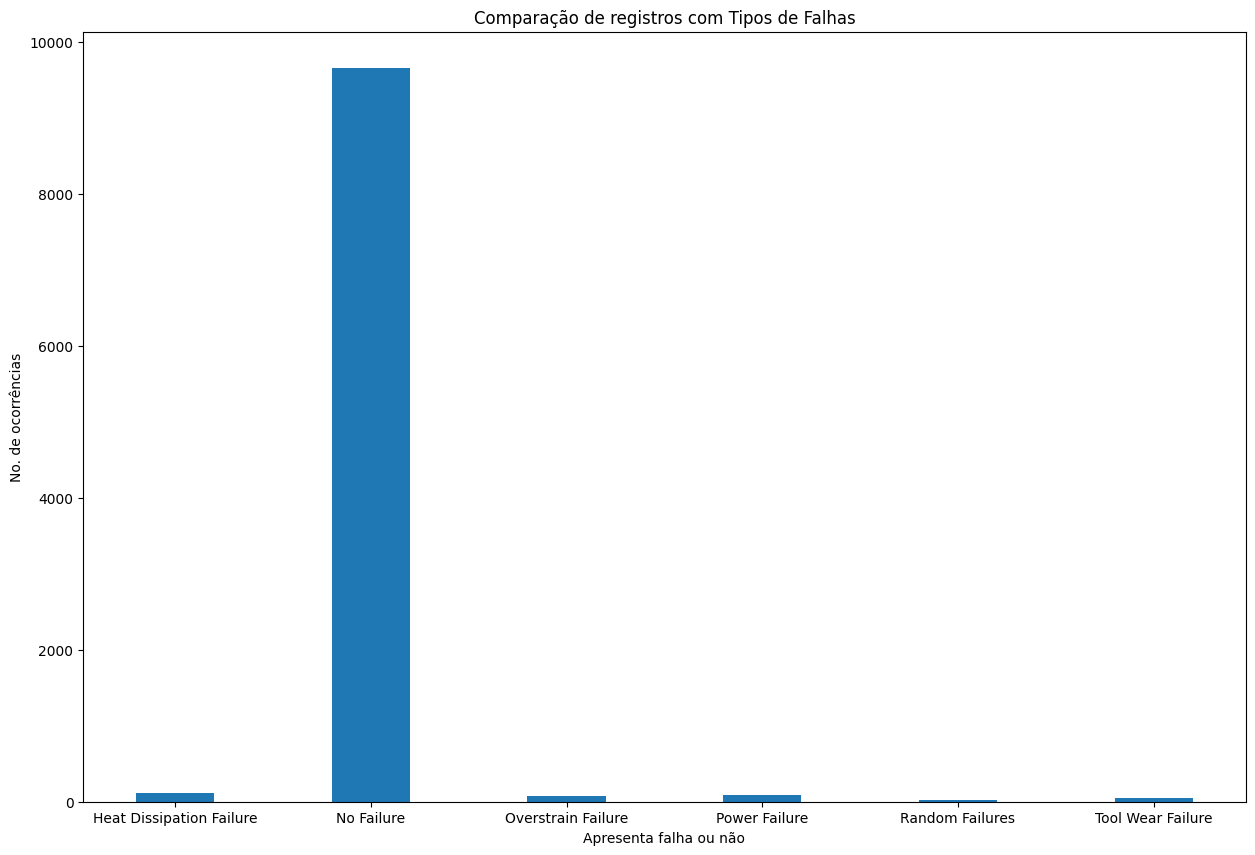

In [ ]:
names, values = np.unique(dataset['Failure Type'], return_counts=True)

fig = plt.figure(figsize=(15,10))
plt.bar(names, values, width = 0.4)
plt.xlabel("Apresenta falha ou não")
plt.ylabel("No. de ocorrências")
plt.title("Comparação de registros com Tipos de Falhas")
plt.show()